In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [2]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [3]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

               length
data_et       2700001
data_trial     132631
data_subject      302


# Create datasets

## Position index

In [4]:
def addPositionIndex(data):
    data['positionIndex'] = 0

    x_pos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.35, 0.65, 0.35, 0.65]
    y_pos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.35, 0.35, 0.65, 0.65]

    for i in range(0, len(x_pos)):
        data.loc[(data['x_pos']==x_pos[i]) & (data['y_pos']==y_pos[i]), 'positionIndex']=i
    return data

data_trial = addPositionIndex(data_trial)

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-calibration'), ['x_pos', 'y_pos', 'positionIndex']] \
    .drop_duplicates() \
    .sort_values(by='positionIndex')

,x_pos,y_pos,positionIndex
41,0.20,0.20,0
27,0.50,0.20,1
17,0.80,0.20,2
21,0.20,0.50,3
37,0.50,0.50,4
33,0.80,0.50,5
39,0.20,0.80,6
31,0.50,0.80,7
29,0.80,0.80,8
25,0.35,0.35,9


## Glasses binary

In [5]:
data_subject['glasses_binary'] = data_subject['sight'] \
    .replace({'contactLenses': 0, 
             'glasses': 1,
             'notCorrected': 0,
             'perfectSight': 0}
           )
print(data_subject['glasses_binary'].unique())

for col in ['glasses', 'sight', 'glasses_binary']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

[ 1.  0. nan]
col_0         count
glasses            
longSight        27
noCorrection    112
progressive      19
shortSight       85


col_0          count
sight               
contactLenses     27
glasses           97
notCorrected      12
perfectSight     107


col_0           count
glasses_binary       
0.0               146
1.0                97




## data_et

In [6]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'task_nr')
data_et = add_var_to_data_et(data_et, data_trial, 'chin')
data_et = add_var_to_data_et(data_et, data_trial, 'chinFirst')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration_exact')
data_et = add_var_to_data_et(data_et, data_trial, 'x_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'y_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'window_width')
data_et = add_var_to_data_et(data_et, data_trial, 'window_height')

## data_trial

In [7]:
if 'glasses_binary' in data_trial.columns:
    data_trial = data_trial.drop(columns=['glasses_binary'])
data_trial = data_trial.merge(
    data_subject.loc[:, ['run_id', 'glasses_binary']],
    on='run_id',
    how='left'
)

## data_et_fix

In [8]:
data_et_fix = data_et.loc[
    (data_et['trial_type']=='eyetracking-fix-object') &
    (data_et['trial_duration']==5000) &
    (data_et['t_task']>1000),     :
]

## data_trial_fix

In [9]:
data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') &
    (data_trial['trial_duration']==5000),     :
].drop(columns=[
    'trial_type', 'trial_duration', 
    'choiceTask_amountLeftFirst',
    'option_topLeft', 'option_bottomLeft',
    'option_topRight', 'option_bottomRight',
    'chosenAmount', 'chosenDelay']
      )

# Screening

## Visually impaired without aids? 

In [10]:
subjects_cannotSee = data_subject.loc[
    (data_subject['sight'] == 'notCorrected') & 
    (data_subject['glasses'] == 'longSight'),
    'run_id']
subjects_cannotSee

122     28
146    307
Name: run_id, dtype: int64

## Not enough trials

In [11]:
NTrials = data_trial.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_notEnoughTrials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
     run_id  trial_index
27       61        271.0
46      125         15.0
51      141         19.0
95      221         19.0
101     229         90.0
151     300         28.0
169     332         26.0
183     351        285.0
194     363        161.0
199     374         18.0
212     392        232.0
248     443         70.0


In [12]:
temp = data_trial_fix.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_notEnoughTrials_fix = temp.loc[temp['trial_index']<131, 'run_id']
temp.loc[temp['trial_index']<131, :]

,run_id,trial_index
27,61,130.0
31,70,130.0


In [13]:
subjects_notEnoughTrials = list(
    set(subjects_notEnoughTrials) | 
    set(subjects_notEnoughTrials_fix)
)
subjects_notEnoughTrials

[229, 70, 392, 363, 300, 141, 332, 61, 125, 374, 443, 221, 351]

## Not following intructions 

In [14]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin
5,12,5b8969006651ea000118e42e,1.0,0.0
48,189,600bb4e0206b7027ab4a4202,0.0,0.0
106,261,5edd5722d3e5b5a717e1b4a2,1.0,0.0
112,269,5f119c5ad521140253f60e86,1.0,0.0
162,336,5fde6c73ad8fba6069f139ed,1.0,0.0
165,339,55a83419fdf99b055f579192,1.0,0.0
202,380,6003361889252e03cebd8fff,0.0,0.0
242,430,5ec00f62cf12be40ea6fe344,1.0,0.0
243,433,6018e18d98e6b01f8c5442de,0.0,1.0
270,48,5fa1192cf99e161a5cfad1cd,1.0,0.0


In [15]:
subjects_noInstruction = data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    'run_id'
].reset_index(drop=True)

## High t_task

In [16]:
data_et_fix.loc[data_et_fix['t_task']>5500, :] \
    .groupby(['run_id'])['x'].count()

run_id
1.0      27
9.0      37
70.0     18
80.0     18
97.0     29
183.0     8
242.0    18
256.0     5
271.0    15
301.0     1
345.0    21
357.0     6
444.0     1
Name: x, dtype: int64

In [17]:
data_trial_fix.loc[data_trial_fix['trial_duration_exact']>5500, :] \
    .groupby(['run_id', 'trial_index']).mean() \
    .reset_index() \
    .loc[:, ['run_id', 'trial_index', 'trial_duration_exact']]

,run_id,trial_index,trial_duration_exact
0,1,106.0,6337.0
1,1,109.0,6371.0
2,1,112.0,6296.0
3,1,115.0,6318.0
4,1,118.0,6310.0
...,...,...,...
226,444,131.0,5507.0
227,444,135.0,5580.0
228,444,498.0,8169.0
229,444,506.0,5543.0


## Not approved by prolific

In [18]:
data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    :
]

,run_id,birthyear,browliner,browser,browser_version,degree,device,ethnic,eyeliner,eyeshadow,...,Country of Birth,Current Country of Residence,Employment Status,First Language,Nationality,Sex,Student Status,Webcam,fps,glasses_binary
7,125,NaN,NaN,Chrome,87.0.4280.88,NaN,Macintosh,NaN,NaN,NaN,...,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,NaN,NaN,NaN
79,229,NaN,NaN,Chrome,88.0.4324.150,NaN,WebKit,NaN,NaN,NaN,...,United States,NaN,Full-Time,NaN,United States,Male,No,Yes,11.411607,NaN
139,300,NaN,NaN,Chrome,88.0.4324.150,NaN,WebKit,NaN,NaN,NaN,...,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,0.105967,NaN
160,332,NaN,NaN,Chrome,88.0.4324.109,NaN,WebKit,NaN,NaN,NaN,...,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,5.800798,NaN
175,351,NaN,NaN,Chrome,88.0.4324.109,NaN,WebKit,NaN,NaN,NaN,...,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,5.592805,NaN
188,363,NaN,NaN,Firefox,85.0,NaN,Macintosh,NaN,NaN,NaN,...,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,16.988636,NaN
195,374,NaN,NaN,Chrome,88.0.4324.150,NaN,WebKit,NaN,NaN,NaN,...,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,0.146712,NaN
251,443,NaN,NaN,Chrome,88.0.4324.150,NaN,Macintosh,NaN,NaN,NaN,...,United States,United States,"Not in paid work (e.g. homemaker', 'retired or...",DATA EXPIRED,United States,Female,Yes,Yes,10.401987,NaN


In [19]:
subjects_notApproved = data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    'run_id'
]
subjects_notApproved

7      125
79     229
139    300
160    332
175    351
188    363
195    374
251    443
Name: run_id, dtype: int64

# Cleaning

In [20]:
excludedSubjects = list(
    set(subjects_notEnoughTrials) | 
    set(subjects_noInstruction) |
    set(subjects_notApproved) |
    set(subjects_cannotSee)
)
excludedSubjects

[261,
 70,
 392,
 9,
 332,
 141,
 12,
 269,
 336,
 339,
 28,
 221,
 351,
 229,
 363,
 300,
 430,
 48,
 433,
 61,
 307,
 374,
 189,
 443,
 380,
 125]

## data_subject variables

In [21]:
data_subject['degree'] = data_subject['degree'].replace({'0': np.nan, '-3.0': np.nan})
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

In [22]:
data_subject = data_subject.loc[~data_subject['run_id'].isin(excludedSubjects), :]
print(data_subject['run_id'].unique())

[  1 103 106 108  11 124 126 128  13 130 131  14 144 146 147 148 149 150
 151 152 153 154 156 157 160 161 162 163 164 165 166 168 171 172 173 176
 177 178 179 180 181 183 185 186 188  19 190 195 196 197 198 199 201 202
 203 204 205 206 207 208 209 210 211 212 213 217 218 219 220 223 224 225
 226 227 230 231 232 233 237 238 239  24 240 241 242 243 244 245 246 247
 248 249  25 253 254 255 256 257 258 259 264 265 266 267 268 270 271 272
 273 274 275 277 278 279 280 281 284 285 286 287 288 289 291 293 294 296
 297 298 299  30 301 302 303 304 305 306 308 309 310 316 318 319  32 322
 324 325 326 327 328 333 337 338 340 341 343 344 345 347 348 349 350 352
 353 354 355 356 357 358 359  36 360 361 362 365 368  37 371 372 373 375
 376 377 378 379  38 381 382 384 386 387 388 389 390 393 394 395 396 397
   4 401 403 404 405 406 407  41 410 411 413 414 416 417 418 419  42 420
 421 422 423 425 427 429  43 434 435 436 437 440 441 442 444 445 446 447
 448 449  45 450 451 454 455 456 457 458 459 460 46

## Trial data

In [23]:
def cleanTrialData(data):
    print('raw data: ' + str(len(data)))
    data = data \
        .loc[~data['run_id'].isin(excludedSubjects), :] \
        .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

print('data_trial')
data_trial = cleanTrialData(data_trial)
print('\n data_trial_fix')
data_trial_fix = cleanTrialData(data_trial_fix)

data_trial
raw data: 132631
cleaned data: 124084

 data_trial_fix
raw data: 4463
cleaned data: 4184


## Eyetracking data
Exclude subjects, and trials with high duration

In [24]:
def cleanETData(data):
    print('raw data: ' + str(len(data)))
    data = data \
        .loc[~data['run_id'].isin(excludedSubjects), :] \
        .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

print('data_et')
data_et = cleanETData(data_et)

print('\n data_et_fix')
data_et_fix = cleanETData(data_et_fix)
data_et_fix = data_et_fix.loc[
    data_et_fix['t_task']<5000,
    :
]

data_et
raw data: 2700001
cleaned data: 2528092

 data_et_fix
raw data: 236962
cleaned data: 220621


# Offset

## Calculate on gaze point-level

In [25]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

data_et.loc[:, "offset"] = euclideanDistance(
        data_et["x"], data_et['x_pos'],
        data_et["y"], data_et['y_pos'])
data_et_fix.loc[:, "offset"] = euclideanDistance(
        data_et_fix["x"], data_et_fix['x_pos'],
        data_et_fix["y"], data_et_fix['y_pos'])

Offset as pixels

In [26]:
data_et.loc[:, "offset_px"] = euclideanDistance(
    (data_et["x"] * data_et['window_width']), 
    (data_et['x_pos'] * data_et['window_width']),
    (data_et["y"] * data_et['window_height']), 
    (data_et['y_pos'] * data_et['window_height'])
)
data_et_fix.loc[:, "offset_px"] = euclideanDistance(
    (data_et_fix["x"] * data_et_fix['window_width']), 
    (data_et_fix['x_pos'] * data_et_fix['window_width']),
    (data_et_fix["y"] * data_et_fix['window_height']), 
    (data_et_fix['y_pos'] * data_et_fix['window_height'])
)
data_et['offset_px'].describe()

count    1.907113e+06
mean     2.202578e+02
std      3.507099e+02
min      1.064561e-01
25%      7.731323e+01
50%      1.452004e+02
75%      2.781190e+02
max      1.127067e+05
Name: offset_px, dtype: float64

In [27]:
print(data_et[['offset', 'offset_px']].describe())
print(data_et_fix[['offset', 'offset_px']].describe())

             offset     offset_px
count  1.907113e+06  1.907113e+06
mean   1.804432e-01  2.202578e+02
std    3.289967e-01  3.507099e+02
min    1.169144e-04  1.064561e-01
25%    6.620303e-02  7.731323e+01
50%    1.253770e-01  1.452004e+02
75%    2.367997e-01  2.781190e+02
max    1.302936e+02  1.127067e+05
              offset      offset_px
count  220035.000000  220035.000000
mean        0.169041     203.990023
std         0.149393     194.812887
min         0.000452       0.531538
25%         0.074879      88.121081
50%         0.127962     149.950492
75%         0.215158     252.217971
max         3.491787    6628.081209


## Plot: gaze shift within a trial

In [28]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data


data_et_fix_task_fixCross = reformatTTask(select_fixTask_and_fixCross(data_et))

def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)

data_trial_fix_task_fixCross = add_next_xy_pos(select_fixTask_and_fixCross(data_trial))

data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

In [29]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [30]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

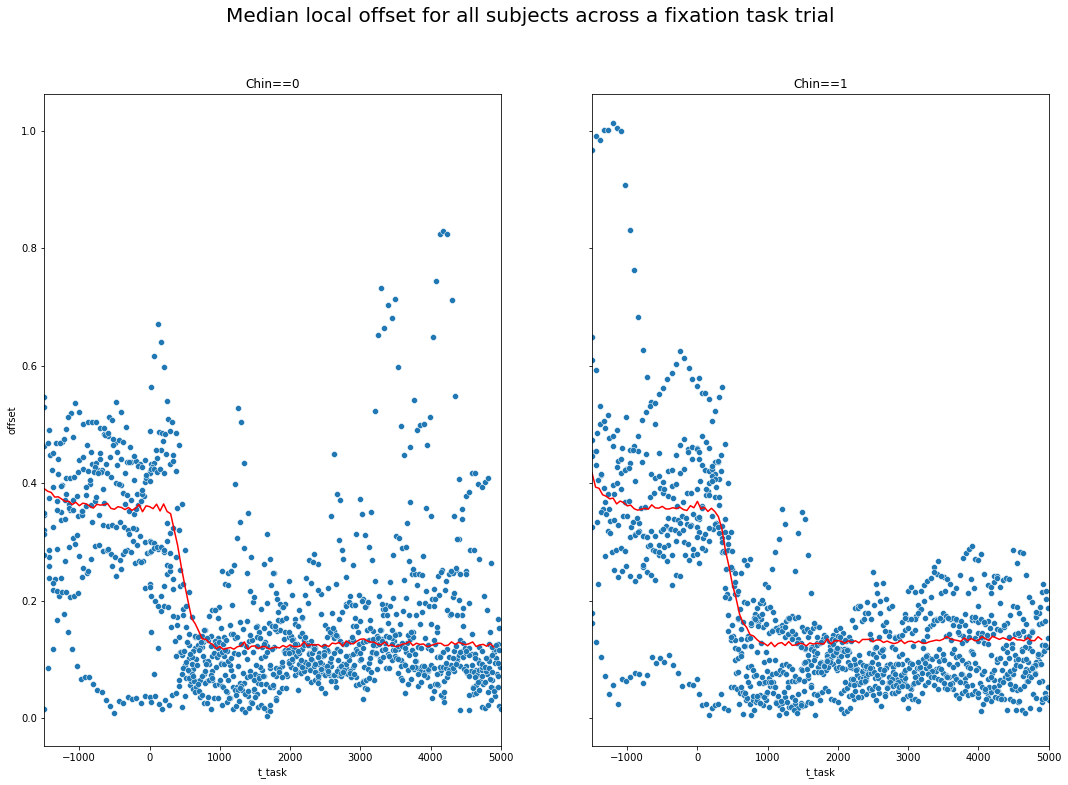

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

## Aggregate on trial level

In [32]:
def merge_varMean_by_index(data, data_et, varName):
    if varName in data.columns: 
        data = data.drop(columns=[varName])
    grouped = data_et.groupby(['run_id', 'trial_index'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_varMean_by_index(data_trial, data_et, 'offset')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset')
data_trial = merge_varMean_by_index(data_trial, data_et, 'offset_px')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset_px')
data_trial_fix['offset']

0       0.126908
1       0.201564
2       0.163404
3       0.117219
4       0.166590
          ...   
4179         NaN
4180         NaN
4181         NaN
4182         NaN
4183         NaN
Name: offset, Length: 4184, dtype: float64

## Fixation task trial index

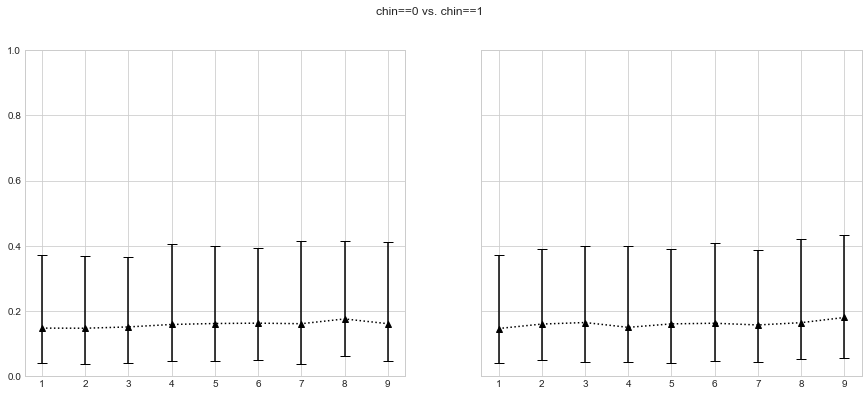

In [33]:
def group_chin_withinTaskIndex(data, varName):
    df_m = data.groupby(['chin', 'withinTaskIndex']) \
        [varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_median'}) \
        .reset_index()

    data = data.merge(df_m, on=['chin', 'withinTaskIndex'], how='left')
    data['above_median'] = data[varName] > data[varName + '_median']
    
    df_std_upper = data.loc[data['above_median']==1, :] \
        .groupby(['chin', 'withinTaskIndex'])[varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_std_upper'}) \
        .reset_index()
    df_std_lower = data.loc[data['above_median']==0, :] \
        .groupby(['chin', 'withinTaskIndex'])[varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_std_lower'}) \
        .reset_index()

    output = pd.concat([
        df_m, 
        df_std_upper[varName + '_std_upper'],
        df_std_lower[varName + '_std_lower']
    ], axis=1)
    return output


data_plot = group_chin_withinTaskIndex(
    data_trial.loc[data_trial['fixTask']==1, :],
    'offset'
)

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chin==0 vs. chin==1')

ax[0].set_ylim(0, 1)

for i in [0, 1]:
    data = data_plot.loc[data_plot['chin']==i, :]
    ax[i].errorbar(
        x = data['withinTaskIndex'], 
        y = data['offset_median'],
        yerr=[data['offset_std_lower'], data['offset_std_upper']],
        fmt='^k:',
        capsize=5
    )
plt.show()

## Fixation positions

In [34]:
data_trial_fix.groupby(['x_pos', 'y_pos']) \
    ['offset'].median() \
    .reset_index()

,x_pos,y_pos,offset
0,0.2,0.2,0.156060
1,0.2,0.5,0.131412
2,0.2,0.8,0.163301
3,0.5,0.2,0.147812
4,0.5,0.5,0.107392
5,0.5,0.8,0.115389
6,0.8,0.2,0.149674
7,0.8,0.5,0.117654
8,0.8,0.8,0.148157


## Aggregate on subject-level 

In [35]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')
data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset_px')

In [36]:
def separate_outcomes_by_condition(data, large_data, varName, varCondition):
    var_cond_0 = varName + '_' + varCondition + '_0' 
    var_cond_1 = varName + '_' + varCondition + '_1' 
    
    if var_cond_0 in data.columns: 
        data = data.drop(columns=[var_cond_0])
    if var_cond_1 in data.columns: 
        data = data.drop(columns=[var_cond_1])
        
    grouped = large_data \
        .groupby(['run_id', varCondition])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns=varCondition, values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_cond_0, 1.0: var_cond_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_cond_0, var_cond_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'chin')

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'offset', 'offset_chin_0', 'offset_chin_1',
        'offset_glasses_binary_0', 'offset_glasses_binary_1'
    ]
].describe()

,offset,offset_chin_0,offset_chin_1,offset_glasses_binary_0,offset_glasses_binary_1
count,227.000000,226.000000,226.000000,133.000000,91.000000
mean,0.178822,0.174820,0.181917,0.177706,0.173351
std,0.112666,0.120503,0.129599,0.121111,0.074989
min,0.053580,0.045764,0.053778,0.053580,0.063450
25%,0.110497,0.106458,0.106316,0.104167,0.116900
50%,0.146943,0.140937,0.144487,0.141081,0.160397
75%,0.212820,0.201206,0.204863,0.206994,0.211397
max,0.826387,1.018857,1.054631,0.803838,0.456543


In [37]:
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'chin')
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'glasses_binary')

data_subject.loc[
    :, 
    [
        'offset_px', 'offset_px_chin_0', 'offset_px_chin_1',
        'offset_px_glasses_binary_0', 'offset_px_glasses_binary_1'
    ]
].describe()

,offset_px,offset_px_chin_0,offset_px_chin_1,offset_px_glasses_binary_0,offset_px_glasses_binary_1
count,227.000000,226.000000,226.000000,133.000000,91.000000
mean,214.597611,206.991095,221.306696,209.564288,210.273488
std,159.906466,153.736527,197.306902,157.642495,115.908527
min,63.404467,53.524854,58.066425,63.404467,63.620122
25%,125.154054,118.683952,123.017406,116.591567,131.883146
50%,169.616320,159.696931,167.551892,154.416383,190.032698
75%,240.876316,233.787859,251.440214,233.801925,242.147189
max,1343.748306,1111.197358,1814.364642,1073.632845,851.448521


## Grand mean offset

In [38]:
grouped = data_et_fix.groupby(['run_id', 'trial_index']) \
    ['x', 'y'].mean() \
    .reset_index() \
    .rename(columns={'x': 'x_mean', 'y': 'y_mean'})

if 'x_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['x_mean'])
if 'y_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['y_mean'])    
data_trial_fix = data_trial_fix.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
) 
data_trial_fix['x_mean_px'] = data_trial_fix['x_mean'] * data_trial_fix['window_width']
data_trial_fix['y_mean_px'] = data_trial_fix['y_mean'] * data_trial_fix['window_height']
data_trial_fix.loc[:, ['x_mean', 'x_mean_px', 'y_mean', 'y_mean_px']].describe()

<ipython-input-38-066a389a9d25>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et_fix.groupby(['run_id', 'trial_index']) \


,x_mean,x_mean_px,y_mean,y_mean_px
count,4063.000000,4063.000000,4063.000000,4063.000000
mean,0.513347,800.724778,0.513344,460.751181
std,0.232137,408.615042,0.213652,214.022450
min,-0.235286,-376.458066,-0.367823,-331.041102
25%,0.317407,500.818801,0.352868,307.801413
50%,0.513281,760.103464,0.521298,451.122973
75%,0.706623,1057.932884,0.674100,592.525031
max,3.633613,6976.536940,2.171791,2280.380605


In [39]:
data_trial_fix['grand_deviation'] = euclideanDistance(
    data_trial_fix['x_mean'], data_trial_fix['x_pos'],
    data_trial_fix['y_mean'], data_trial_fix['y_pos']
)
data_trial_fix['grand_deviation'].describe()

count    4063.000000
mean        0.164516
std         0.159349
min         0.000995
25%         0.069696
50%         0.122501
75%         0.208662
max         3.491787
Name: grand_deviation, dtype: float64

# Precision

## Distance from AVG on et-level

In [40]:
def merge_xy_means(data):    
    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    
    if 'x_mean' in data.columns: 
        data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: 
        data = data.drop(columns=['y_mean'])
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG_square(data):
    data = merge_xy_means(data)
    data['distanceFromAVG_square'] = np.power(
        euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean']),
        2
    )
    data['distanceFromAVG_square_px'] = np.power(euclideanDistance(
        (data['x'] * data_et['window_width']), 
        (data['x_mean'] * data_et['window_width']), 
        (data['y'] * data_et['window_height']), 
        (data['y_mean'] * data_et['window_height'])
    ), 2)
    
    return(data)  

data_et = distanceFromAVG_square(data_et)
data_et_fix = distanceFromAVG_square(data_et_fix)
print(data_et_fix.loc[
    pd.isna(data_et_fix['distanceFromAVG_square']), 
    ['x', 'y', 'x_pos', 'y_pos', 'distanceFromAVG_square']
])
data_et_fix.loc[
    :, ['distanceFromAVG_square', 'distanceFromAVG_square_px']] \
    .describe()

<ipython-input-40-ca53af98e2a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \


Empty DataFrame
Columns: [x, y, x_pos, y_pos, distanceFromAVG_square]
Index: []


,distanceFromAVG_square,distanceFromAVG_square_px
count,220035.000000,2.200350e+05
mean,0.007189,9.340337e+03
std,0.025965,2.782937e+04
min,0.000000,0.000000e+00
25%,0.000825,1.024317e+03
50%,0.002432,3.113095e+03
75%,0.006348,8.359565e+03
max,3.006582,1.784821e+06


## Aggregate standard deviation on trial-level

In [41]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square')
data_trial['precision'] = np.sqrt(data_trial['distanceFromAVG_square'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square')
data_trial_fix['precision'] = np.sqrt(data_trial_fix['distanceFromAVG_square'])
print(data_trial_fix['precision'].describe())

count    4063.000000
mean        0.071763
std         0.044401
min         0.000000
25%         0.046711
50%         0.062380
75%         0.086441
max         0.714282
Name: precision, dtype: float64


In pixel

In [42]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square_px')
data_trial['precision_px'] = np.sqrt(data_trial['distanceFromAVG_square_px'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square_px')
data_trial_fix['precision_px'] = np.sqrt(data_trial_fix['distanceFromAVG_square_px'])
print(data_trial_fix['precision_px'].describe())

count    4063.000000
mean       82.974585
std        51.457422
min         0.000000
25%        52.325789
50%        71.700514
75%        98.944254
max       876.150962
Name: precision_px, dtype: float64


Any missing values?

In [43]:
data_trial_fix.loc[
    pd.isna(data_trial_fix['precision']), 
    ['run_id', 'trial_index', 'x_pos', 'y_pos', 'precision']
]

,run_id,trial_index,x_pos,y_pos,precision
2439,355,107.0,0.5,0.2,NaN
2440,355,111.0,0.5,0.8,NaN
2441,355,115.0,0.2,0.2,NaN
2442,355,119.0,0.2,0.5,NaN
2443,355,123.0,0.2,0.8,NaN
...,...,...,...,...,...
4179,98,243.0,0.8,0.2,NaN
4180,98,246.0,0.2,0.8,NaN
4181,98,249.0,0.2,0.5,NaN
4182,98,252.0,0.5,0.5,NaN


## Precision across trials

In [44]:
data_plot = group_chin_withinTaskIndex(
    data_trial.loc[data_trial['fixTask']==1, :],
    'precision'
)
data_plot

,index,chin,withinTaskIndex,precision_median,precision_std_upper,precision_std_lower
0,0,0.0,1.0,0.109654,0.135458,0.083998
1,1,0.0,2.0,0.102130,0.140369,0.083928
2,2,0.0,3.0,0.107954,0.134545,0.086865
3,3,0.0,4.0,0.109600,0.132190,0.087316
4,4,0.0,5.0,0.107573,0.131768,0.084164
5,5,0.0,6.0,0.105362,0.131983,0.083393
6,6,0.0,7.0,0.109592,0.140524,0.083184
7,7,0.0,8.0,0.107702,0.130629,0.083391
8,8,0.0,9.0,0.108001,0.135398,0.084325
9,9,1.0,1.0,0.113283,0.140445,0.083709


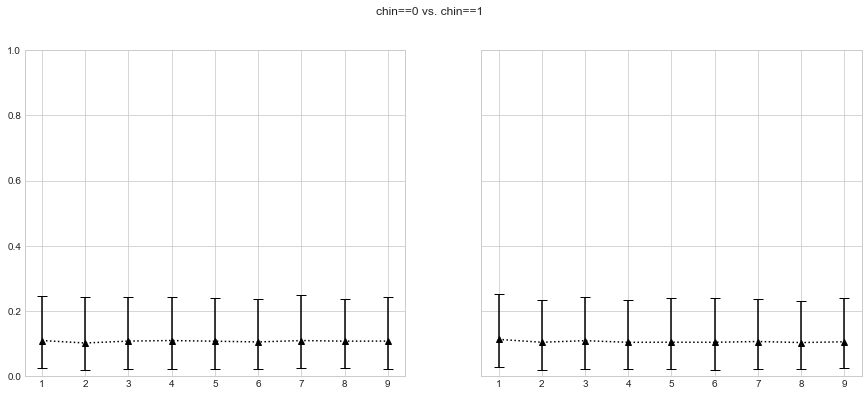

In [45]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chin==0 vs. chin==1')

ax[0].set_ylim(0, 1)

for i in [0, 1]:
    data = data_plot.loc[data_plot['chin']==i, :]
    ax[i].errorbar(
        x = data['withinTaskIndex'], 
        y = data['precision_median'],
        yerr=[data['precision_std_lower'], data['precision_std_upper']],
        fmt='^k:',
        capsize=5
    )
plt.show()

## Aggregate on subject-level 

In [46]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision', 'precision_chin_0', 'precision_chin_1',
        'precision_glasses_binary_0', 'precision_glasses_binary_1'
    ]
].describe()

,precision,precision_chin_0,precision_chin_1,precision_glasses_binary_0,precision_glasses_binary_1
count,227.000000,226.000000,226.000000,133.000000,91.000000
mean,0.071651,0.072566,0.070820,0.069917,0.074550
std,0.028969,0.030296,0.036051,0.031569,0.023717
min,0.000000,0.000000,0.000000,0.000002,0.000002
25%,0.055574,0.056728,0.053084,0.054423,0.061697
50%,0.067120,0.069096,0.064887,0.064402,0.070567
75%,0.083966,0.082575,0.080607,0.082785,0.085315
max,0.270525,0.284938,0.408137,0.270525,0.175707


In pixel

In [47]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision_px')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision_px', 'precision_px_chin_0', 'precision_px_chin_1',
        'precision_px_glasses_binary_0', 'precision_px_glasses_binary_1'
    ]
].describe()

,precision_px,precision_px_chin_0,precision_px_chin_1,precision_px_glasses_binary_0,precision_px_glasses_binary_1
count,227.000000,226.000000,226.000000,133.000000,91.000000
mean,82.809093,83.744288,82.041419,80.574413,86.607882
std,35.001858,36.608158,41.101433,34.777900,34.592512
min,0.000000,0.000000,0.000000,0.002056,0.003971
25%,63.316420,62.731327,58.733259,61.627400,66.194767
50%,76.594442,78.004995,75.589600,75.563597,78.902940
75%,96.083682,97.758685,96.559394,92.509809,100.081502
max,256.587017,241.668583,391.176827,256.587017,202.306597


# chinFirst: Randomization worked? 

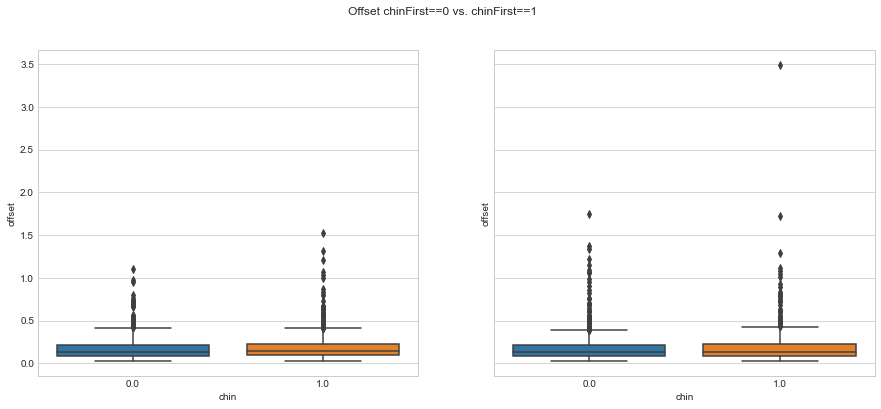

In [48]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

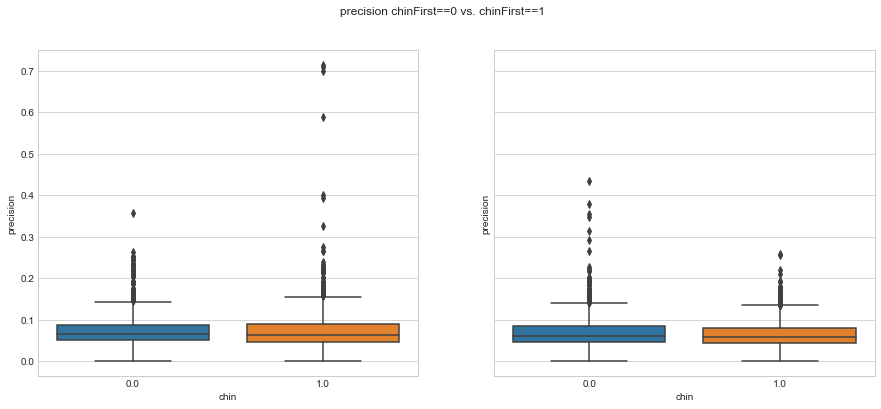

In [49]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

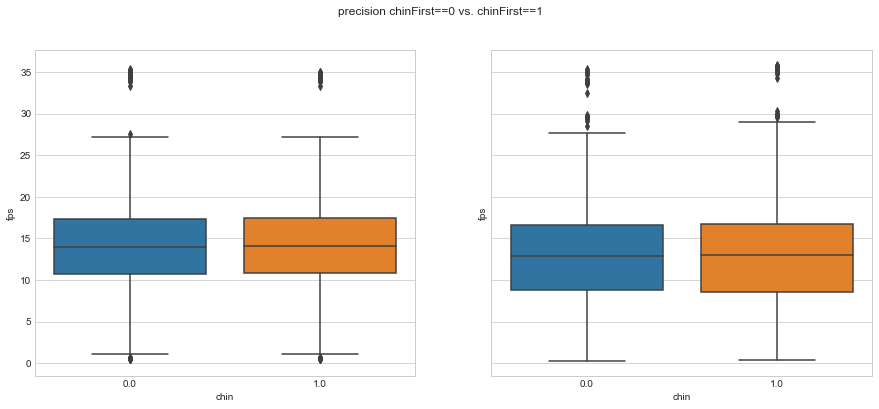

In [50]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='fps', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='fps', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

# Main effect: chin-rest
 - t-tests will follow
 - TODO: Compare subjects with high fps (Semmelmann & Weigelt, 2019)

In [51]:
data_trial_fix['fps'].median()
data_trial_fix['high_fps']=0
data_trial_fix.loc[
    data_trial_fix['fps']>data_trial_fix['fps'].median(),
    'high_fps'
]=1

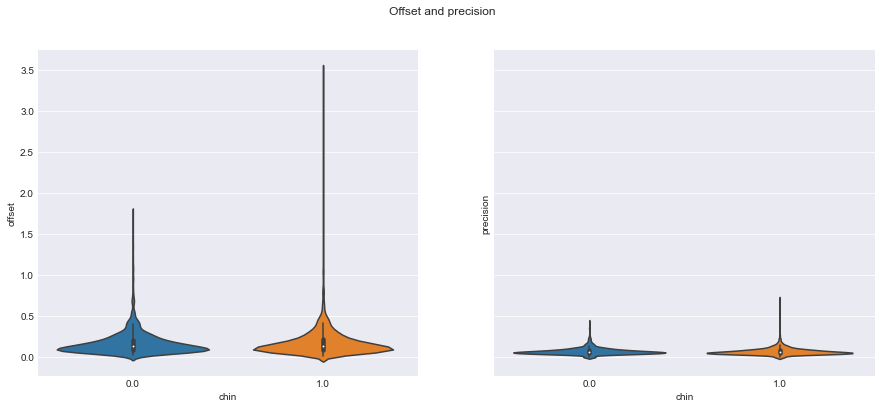

In [80]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset and precision')

sns.violinplot(ax=axes[0], 
               x='chin', 
               y='offset', 
               data=data_trial_fix)
sns.violinplot(ax=axes[1], 
               x='chin', 
               y='precision', 
               data=data_trial_fix)
   
plt.show()

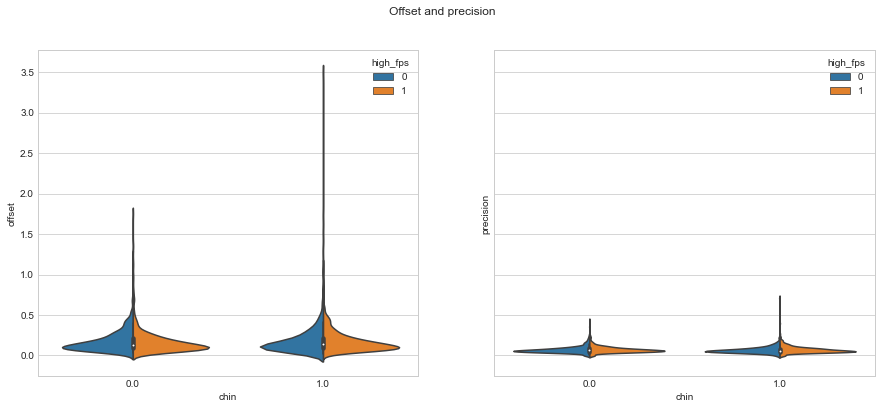

In [52]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset and precision')

sns.violinplot(ax=axes[0], 
               x='chin', 
               y='offset', 
               hue='high_fps',
               split=True,
               data=data_trial_fix)
sns.violinplot(ax=axes[1], 
               x='chin', 
               y='precision', 
               hue='high_fps',
               split=True,
               data=data_trial_fix)
   
plt.show()

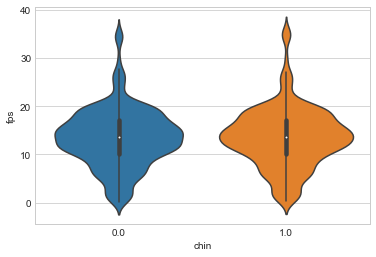

In [53]:
sns.violinplot(x='chin', y='fps', data=data_trial_fix)   
plt.show()

In [54]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

,index,mean,var
0,offset_chin_0,0.174820,0.014521
1,offset_chin_1,0.181917,0.016796
2,precision_chin_0,0.072566,0.000918
3,precision_chin_1,0.070820,0.001300


In [55]:
test_data = data_subject.loc[
    pd.notna(data_subject['offset_chin_0']) & 
    pd.notna(data_subject['offset_chin_1']), :]
scipy.stats.ttest_rel(test_data['offset_chin_0'], test_data['offset_chin_1'])

Ttest_relResult(statistic=-1.0203348446416038, pvalue=0.3086703995888803)

## offset across fixation positions

In [56]:
data_trial_fix.groupby(['chin', 'x_pos', 'y_pos']) \
    ['offset'].mean() \
    .reset_index()

# rej, pval_corr = smm.multipletests(pval_raw, alpha=alpha, method='h')[:2]

,chin,x_pos,y_pos,offset
0,0.0,0.2,0.2,0.193501
1,0.0,0.2,0.5,0.161514
2,0.0,0.2,0.8,0.197536
3,0.0,0.5,0.2,0.188901
4,0.0,0.5,0.5,0.134056
5,0.0,0.5,0.8,0.151791
6,0.0,0.8,0.2,0.197702
7,0.0,0.8,0.5,0.158656
8,0.0,0.8,0.8,0.185746
9,1.0,0.2,0.2,0.191542


## Offset & precision across fixation dot positions

In [57]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

chin
positionIndex           4.000000
offset_chin_0           0.174378
offset_chin_1           0.181917
offset_var_chin_0       0.020311
offset_var_chin_1       0.027614
precision_chin_0        0.072711
precision_chin_1        0.070820
precision_var_chin_0    0.001643
precision_var_chin_1    0.002230
dtype: float64


<ipython-input-57-15d38b239ff3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
<ipython-input-57-15d38b239ff3>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \


chin,positionIndex,offset_chin_0,offset_chin_1,offset_var_chin_0,offset_var_chin_1,precision_chin_0,precision_chin_1,precision_var_chin_0,precision_var_chin_1
0,0,0.193501,0.191542,0.020256,0.020036,0.082131,0.080660,0.001787,0.002109
1,1,0.188901,0.186452,0.021787,0.017443,0.075674,0.073969,0.001804,0.003096
2,2,0.197702,0.196031,0.032941,0.024470,0.084287,0.079831,0.002211,0.003197
3,3,0.161514,0.177051,0.011873,0.064338,0.072836,0.068173,0.001735,0.001569
4,4,0.134056,0.138122,0.010378,0.010778,0.063383,0.061032,0.001749,0.001090
5,5,0.158656,0.164576,0.021392,0.020601,0.072570,0.066520,0.001606,0.001003
6,6,0.197536,0.208016,0.023709,0.025116,0.071408,0.070734,0.001177,0.003466
7,7,0.151791,0.175074,0.017259,0.034105,0.063536,0.066492,0.001250,0.002659
8,8,0.185746,0.200388,0.023201,0.031640,0.068571,0.069971,0.001471,0.001880


# Main effect: Visual Aid

## Frequency of visual aids

In [58]:
for col in ['glasses', 'sight', 'glasses_binary']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0         count
glasses            
longSight        23
noCorrection    106
progressive      18
shortSight       83


col_0          count
sight               
contactLenses     26
glasses           93
notCorrected      10
perfectSight     101


col_0           count
glasses_binary       
0.0               137
1.0                93




## offset & precision on subject-level

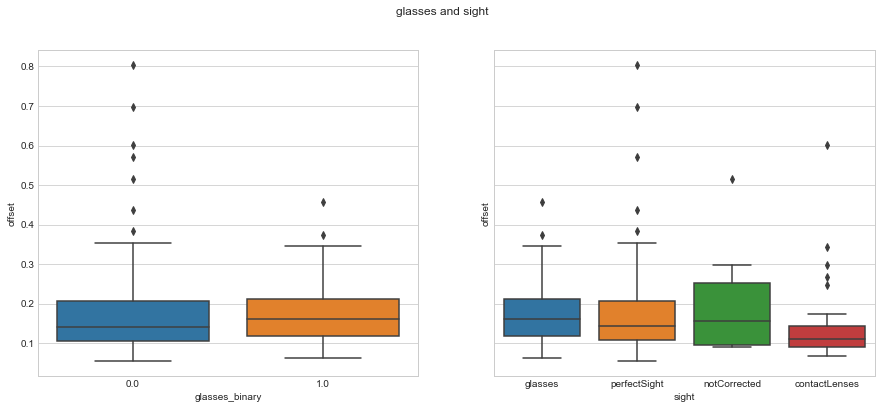

In [59]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='offset', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='offset', data=data_subject)
   
plt.show()

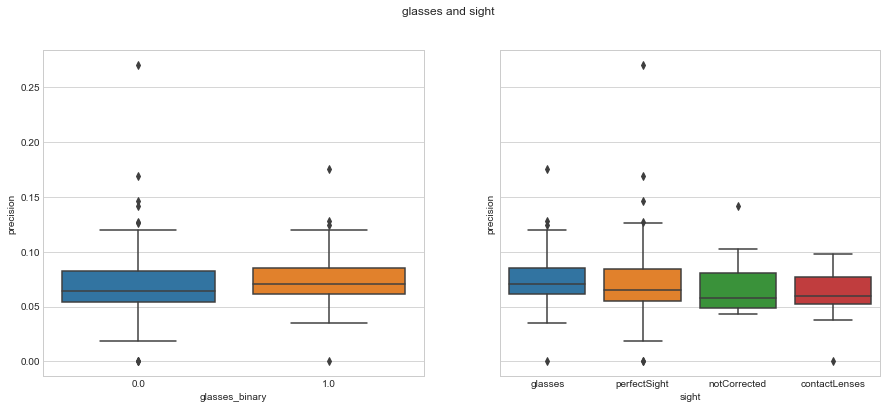

In [60]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='precision', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='precision', data=data_subject)
   
plt.show()

# Gaze predictions

## Gaze dot positions for each position

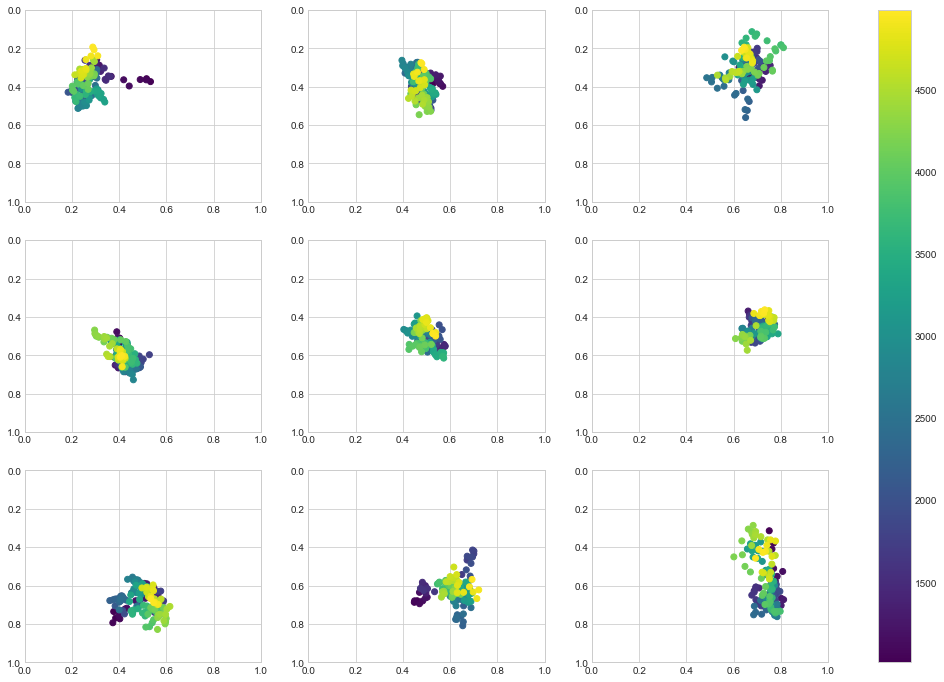

In [61]:
data_plot = add_var_to_data_et(data_et_fix, data_trial, 'chin')
data_plot = data_plot.loc[
    (data_plot['run_id']==43) & 
    (data_plot['chin']==0), :]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[(data_plot['x_pos']==xPos[i]) & (data_plot['y_pos']==yPos[i]), :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

## Heatmap

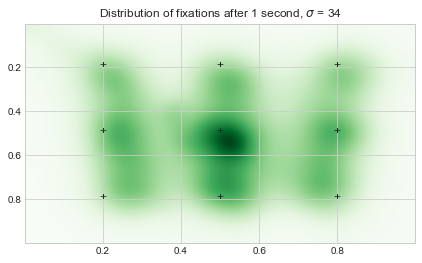

<Figure size 432x288 with 0 Axes>

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

x = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'x']

y = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent

s=34
img, extent = myplot(x, y, s=s)

plt.figure(figsize=(7, 7))
plt.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))
plt.title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)


xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '+', size=12, ha="center")

plt.show()
plt.savefig('plots/fix_heatmap.png')

# Additional analyis

## Median offset across calibration trials
Does data quality improve during calibration? 

In [63]:
data_et_calibration = data_et.loc[data_et['trial_type']=='eyetracking-calibration', :]
data_trial_calibration = data_trial \
    .loc[data_trial['trial_type']=='eyetracking-calibration', :]

# Add median offset 
grouped = data_et_calibration \
    .groupby(['run_id', 'trial_index'])['offset'].median() \
    .reset_index() \
    .rename(columns={'offset': 'offset_median'}) 
data_trial_calibration = data_trial_calibration.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


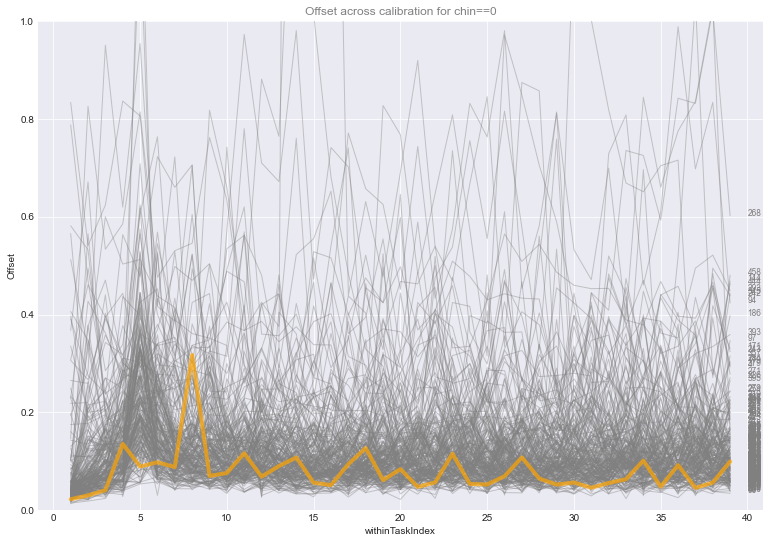

In [64]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(13, 9))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset_median', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


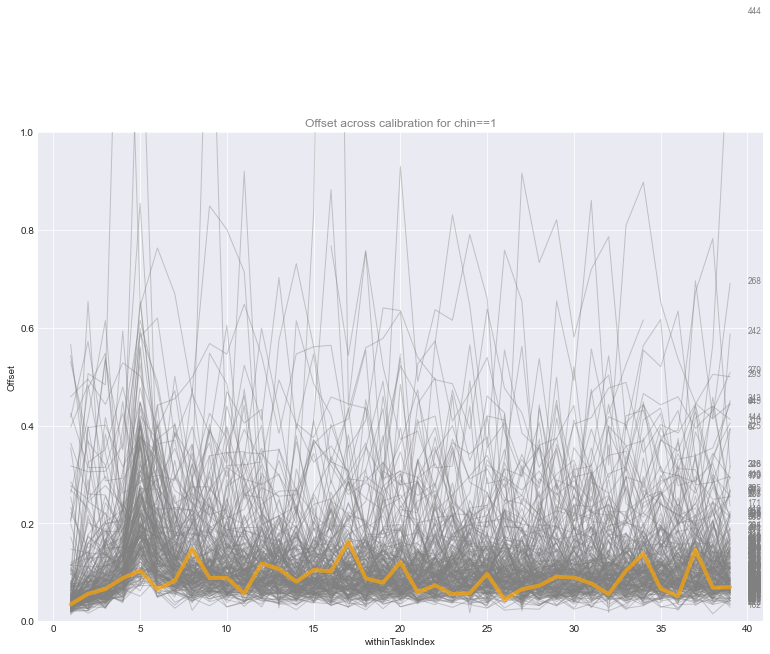

In [65]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset_median', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

## Median precision across calibration trials

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


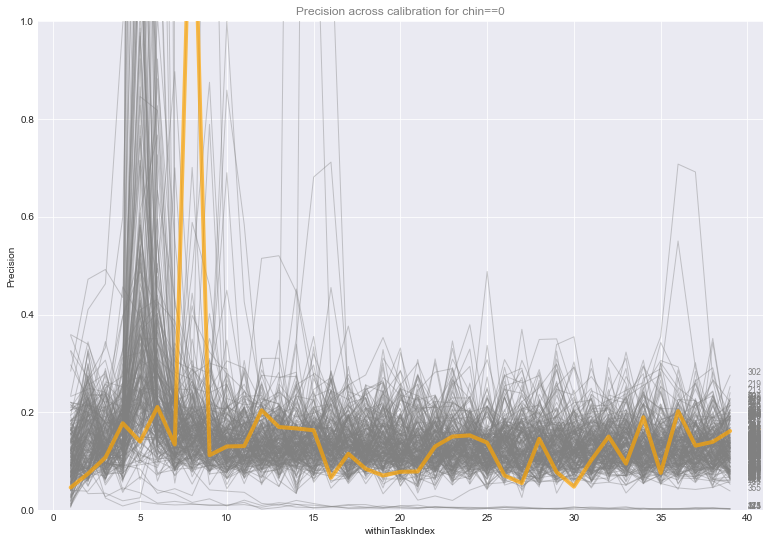

In [66]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


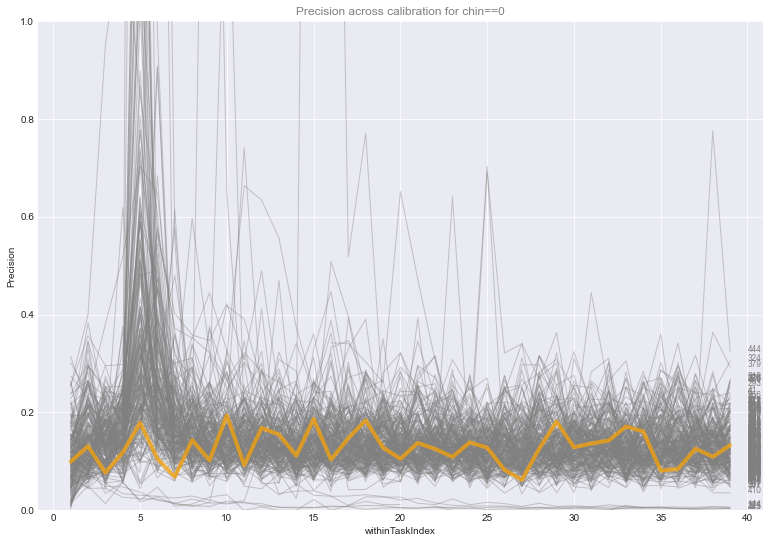

In [67]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

## Categorical confounders

In [68]:
predictors = [
    'vertPosition', 'gender', 'ethnic',  
    'degree', 'browser', 'glasses', 'sight', 'sight']  
for col in predictors:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0         count
vertPosition       
a                91
b               109
c                30


col_0    count
gender        
diverse      4
female     106
male       120


col_0      count
ethnic          
asian         45
black         17
caucasian    149
hispanic      19


col_0    count
degree        
college    117
grad        40
high        63
middle       2


col_0    count
browser       
Chrome     215
Edge        17
Firefox     30
Opera        4
Safari      10


col_0         count
glasses            
longSight        23
noCorrection    106
progressive      18
shortSight       83


col_0          count
sight               
contactLenses     26
glasses           93
notCorrected      10
perfectSight     101


col_0          count
sight               
contactLenses     26
glasses           93
notCorrected      10
perfectSight     101




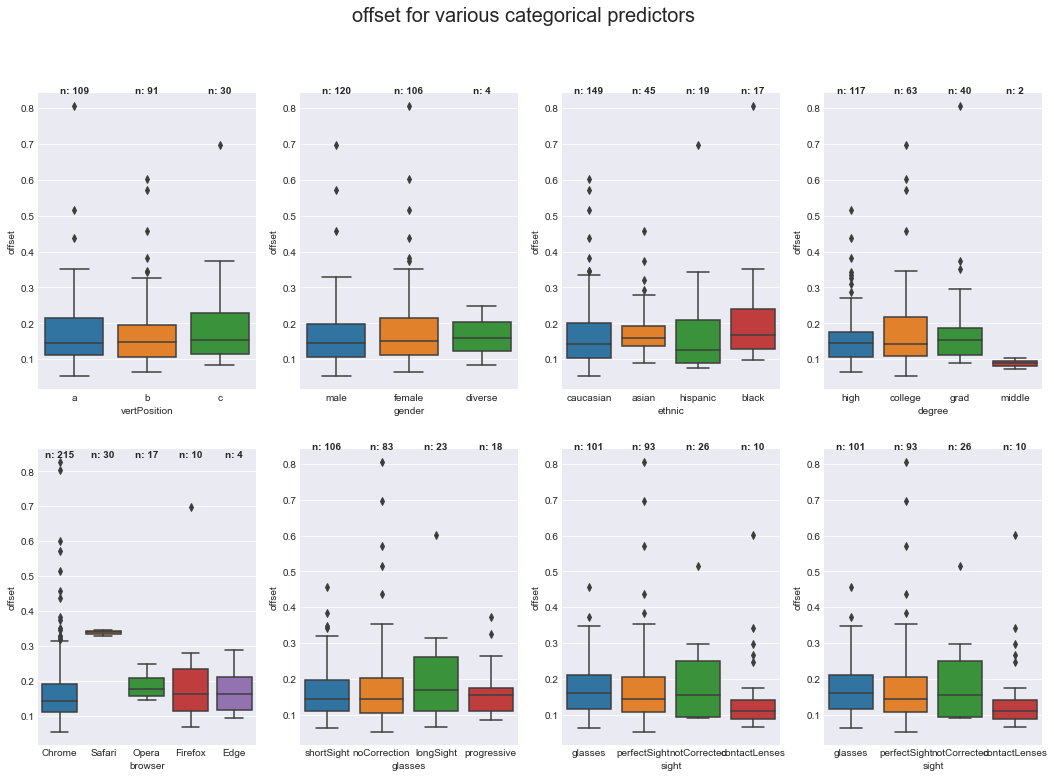

In [69]:
def getBoxPlots(outcome, yPos):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 12))
    fig.suptitle(outcome + ' for various categorical predictors', fontsize=20)
    ax = ax.ravel()
    for i in range(0, 8):
        sns.boxplot(ax=ax[i], x=predictors[i], y=outcome, data=data_subject)
        nobs = data_subject[predictors[i]].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = ["n: " + i for i in nobs]
        # Add it to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax[i].get_xticklabels()):
            ax[i].text(pos[tick], yPos, nobs[tick], # medians[tick] + 0.02
            verticalalignment='top',
            horizontalalignment='center', size='medium', weight='semibold')
            
getBoxPlots('offset', 0.86)

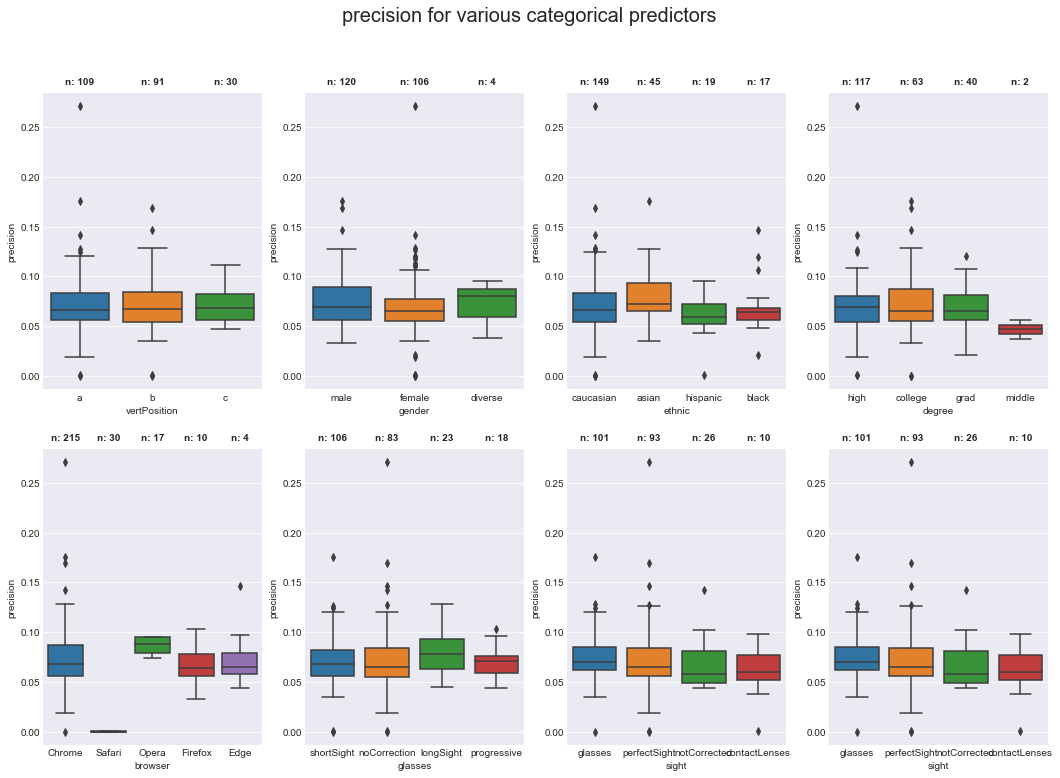

In [79]:
getBoxPlots('precision', yPos=0.30)

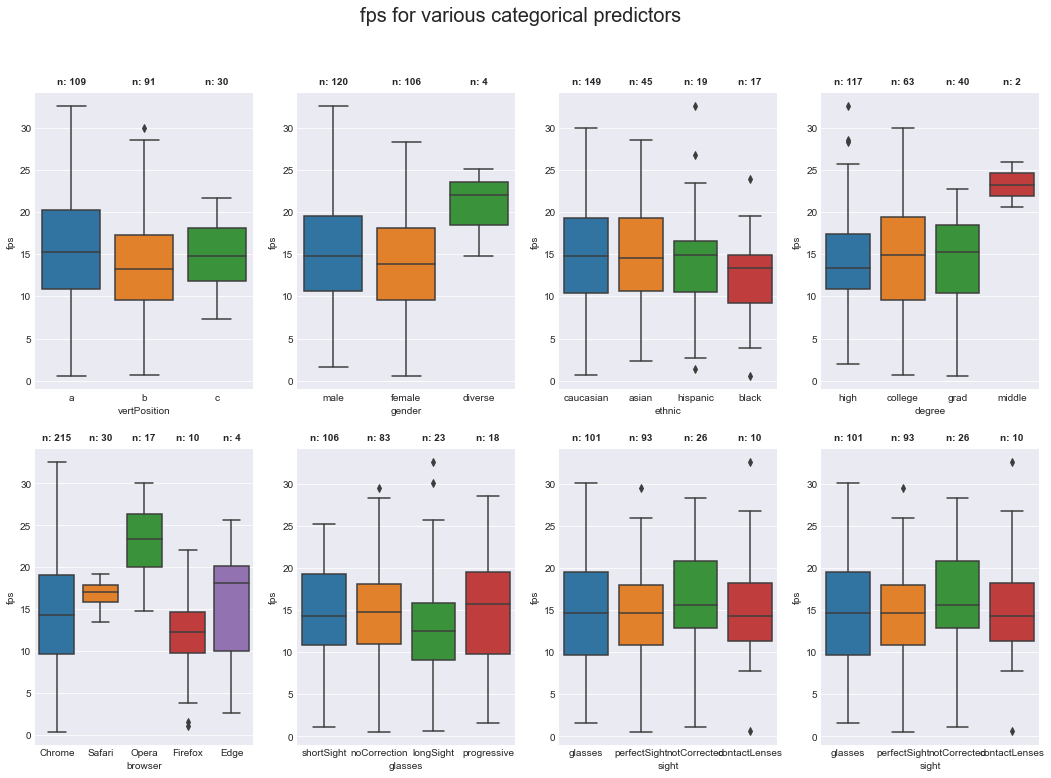

In [71]:
getBoxPlots('fps', yPos=36)

## Correlation Plot

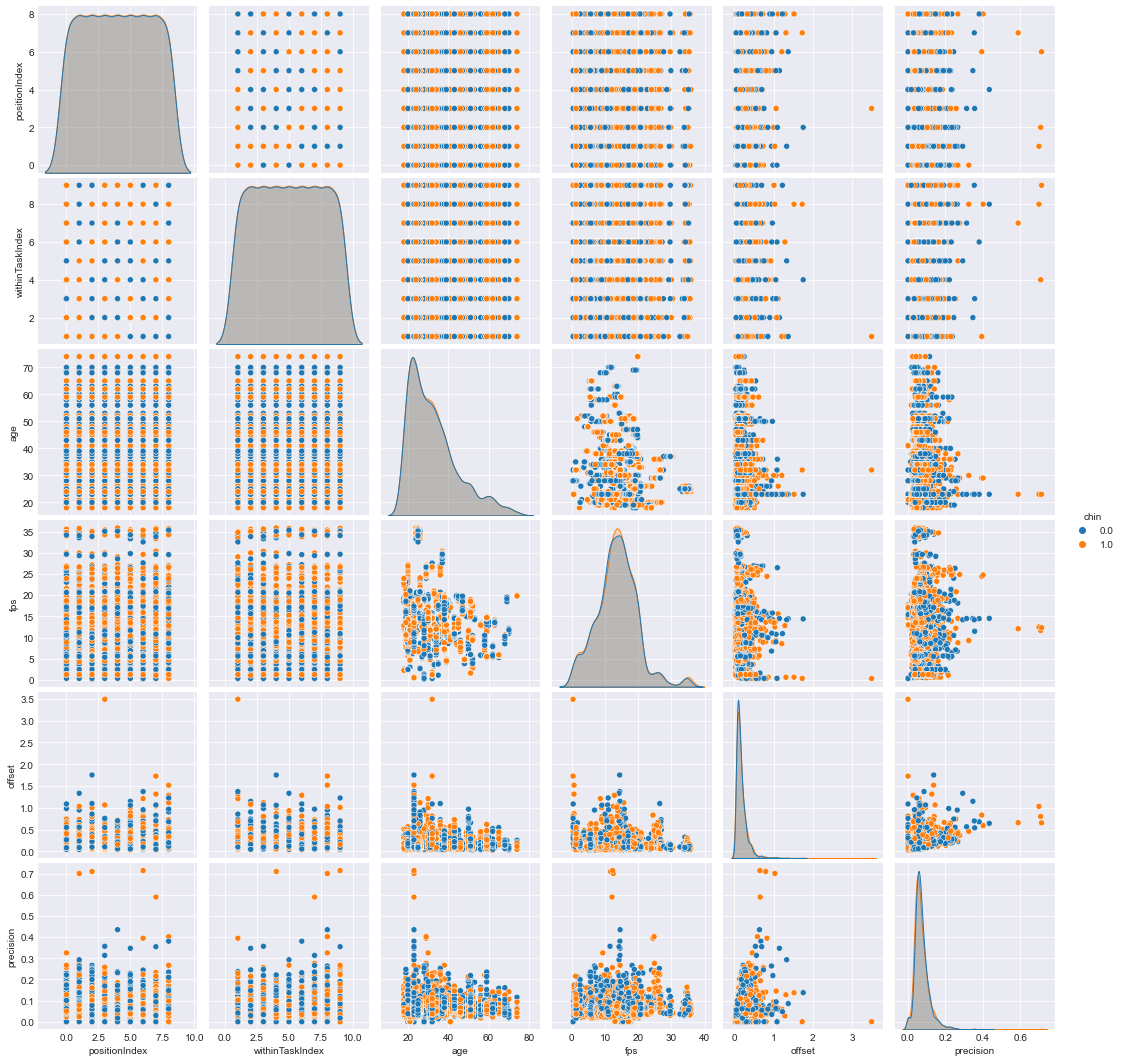

In [72]:
data_plot = data_trial_fix.merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left')
correlation_columns = ['positionIndex', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.pairplot(data_plot.loc[:, np.append(correlation_columns, ['chin'])], hue='chin')

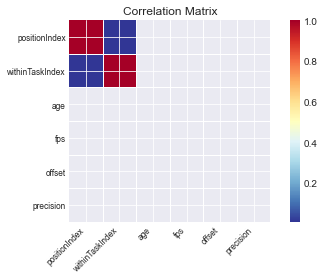

In [73]:
corr_matrix = np.corrcoef(data_plot[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [74]:
data_plot[correlation_columns].rcorr()

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,,,,,***
withinTaskIndex,0.011,-,,,,**
age,0.0,0.0,-,***,,
fps,0.0,0.004,-0.144,-,***,
offset,-0.018,0.022,-0.021,-0.127,-,***
precision,-0.098,0.05,-0.001,0.03,0.272,-


In [75]:
data_plot[correlation_columns].rcorr(upper='n')

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,4184,4094,4065,4063,4063
withinTaskIndex,0.011,-,4094,4065,4063,4063
age,0.0,0.0,-,3975,3973,3973
fps,0.0,0.004,-0.144,-,4063,4063
offset,-0.018,0.022,-0.021,-0.127,-,4063
precision,-0.098,0.05,-0.001,0.03,0.272,-


# MLA Model

In [76]:
data_plot = data_trial_fix.loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]
data_plot = data_plot.loc[pd.notna(data_plot['precision']), :].reset_index(drop=True)
data_plot.loc[data_plot.isnull().any(axis=1), :]
model = smf.mixedlm("precision ~ x_pos", data_plot, groups=data_plot["run_id"])
model_fit = model.fit()
print(model_fit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: precision
No. Observations: 4063    Method:             REML     
No. Groups:       227     Scale:              0.0012   
Min. group size:  5       Log-Likelihood:     7583.5969
Max. group size:  18      Converged:          Yes      
Mean group size:  17.9                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.072    0.002 32.563 0.000  0.068  0.077
x_pos        -0.001    0.002 -0.537 0.592 -0.006  0.003
Group Var     0.001    0.002                           



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Export

In [77]:
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)

data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)

data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [78]:
print('Success! Script ran through')

Success! Script ran through
